In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from geopy.distance import geodesic
import joblib

In [2]:
df = pd.read_csv('dataset.csv')
pd.options.display.max_columns = None
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
df.shape

(1296675, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
df.duplicated().any()

False

In [7]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hours'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

In [8]:
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'job', 'trans_num']
df = df.drop(columns=drop_columns)

In [9]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hours,day,month
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1


In [10]:
cat_col = ['merchant', 'category', 'gender']
encoders ={}
for col in cat_col:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

In [11]:
def haversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b), (c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [12]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hours,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [13]:
features = ['merchant', 'category', 'amt', 'cc_num', 'hours', 'day', 'month', 'gender', 'distance']
x = df[features]
y = df['is_fraud'] 

In [14]:
df['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

C:\Users\DELL\AppData\Local\Temp\ipykernel_9276\3929186405.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='is_fraud', palette='Set2')


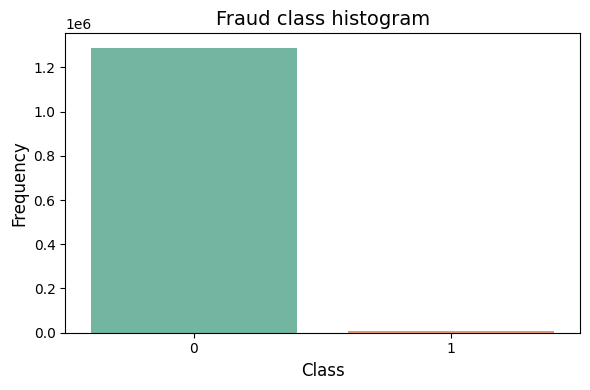

In [15]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_fraud', palette='Set2')

plt.title('Fraud class histogram', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0, 1], ['0', '1'])
plt.tight_layout()
plt.show()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [59]:
#Bước 2: SMOTE + ENN
smote_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smote_enn.fit_resample(x_train, y_train)

In [ ]:
#smote = SMOTE(random_state=42)
#x_resample, y_resample = smote.fit_resample(x_train, y_train)

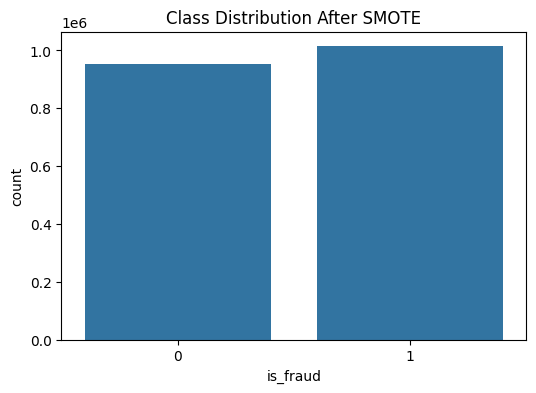

In [60]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [61]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    criterion='gini',        # hoặc 'entropy'
    max_depth=10,            # Giới hạn độ sâu để tránh overfitting
    min_samples_split=10,    # Số mẫu tối thiểu để chia node
    min_samples_leaf=5,      # Số mẫu tối thiểu tại node lá
    class_weight='balanced', # Tự động cân bằng class
    random_state=42
)

dt_model.fit(x_resample,y_resample)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [62]:
y_pred = dt_model.predict(x_test)

In [63]:
print("classification_Tree Decision_Report:\n", classification_report(y_test,y_pred))
print("Roc Auc Score: ", roc_auc_score(y_test,y_pred))

classification_Tree Decision_Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93    257186
           1       0.96      0.89      0.92    258482

    accuracy                           0.93    515668
   macro avg       0.93      0.93      0.93    515668
weighted avg       0.93      0.93      0.93    515668

Roc Auc Score:  0.9273388344260954


C:\Users\DELL\AppData\Local\Temp\ipykernel_9276\909075361.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette=colors)


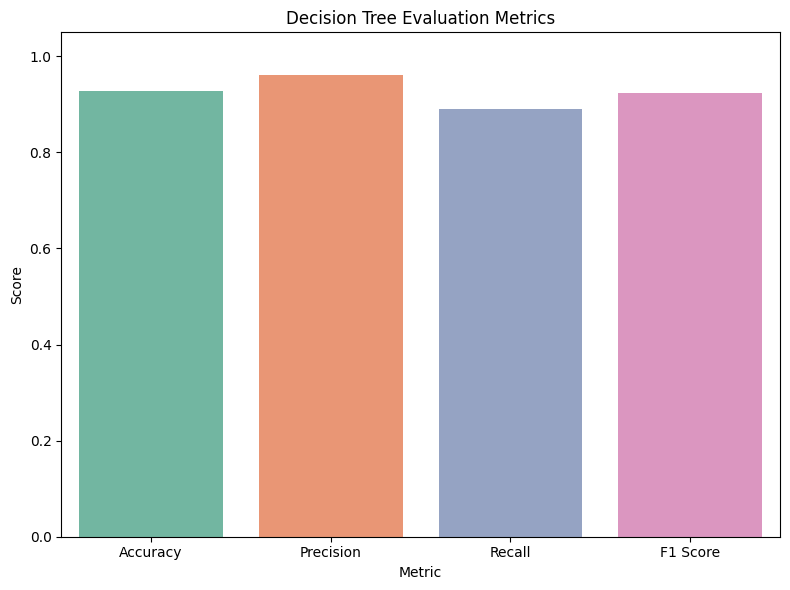

In [64]:
# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Biểu đồ các chỉ số
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=metrics, palette=colors)
plt.ylim(0.0, 1.05)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.title('Decision Tree Evaluation Metrics')
plt.grid(False)
plt.tight_layout()
plt.show()


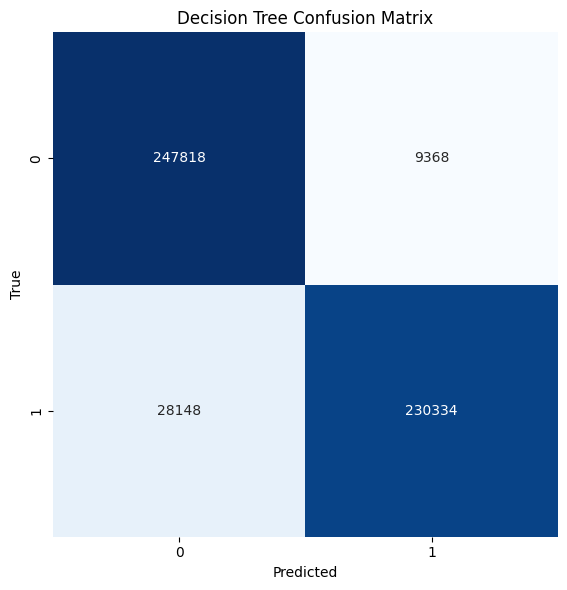

In [65]:
# Tạo confusion matrix và vẽ biểu đồ heatmap như trong hình
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Decision Tree Confusion Matrix')
plt.tight_layout()
plt.show()

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,         # Số cây trong rừng
    max_depth=20,             # Độ sâu tối đa
    min_samples_split=10,     # Tối thiểu để chia
    min_samples_leaf=5,       # Tối thiểu tại node lá
    max_features='sqrt',      # Số đặc trưng chọn khi chia
    class_weight='balanced',  # Giúp xử lý mất cân bằng
    random_state=42,
    n_jobs=-1                 # Tận dụng đa lõi
)

rf_model.fit(x_resample,y_resample)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, min_samples_split=10, n_jobs=-1,
                       random_state=42)

In [67]:
y_pred = rf_model.predict(x_test)

In [68]:
print("classification_Random Forest_Report:\n", classification_report(y_test,y_pred))
print("Roc Auc Score: ", roc_auc_score(y_test,y_pred))

classification_Random Forest_Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97    257186
           1       0.98      0.95      0.96    258482

    accuracy                           0.96    515668
   macro avg       0.96      0.96      0.96    515668
weighted avg       0.96      0.96      0.96    515668

Roc Auc Score:  0.9646403327180542


C:\Users\DELL\AppData\Local\Temp\ipykernel_9276\3573152067.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette=colors)


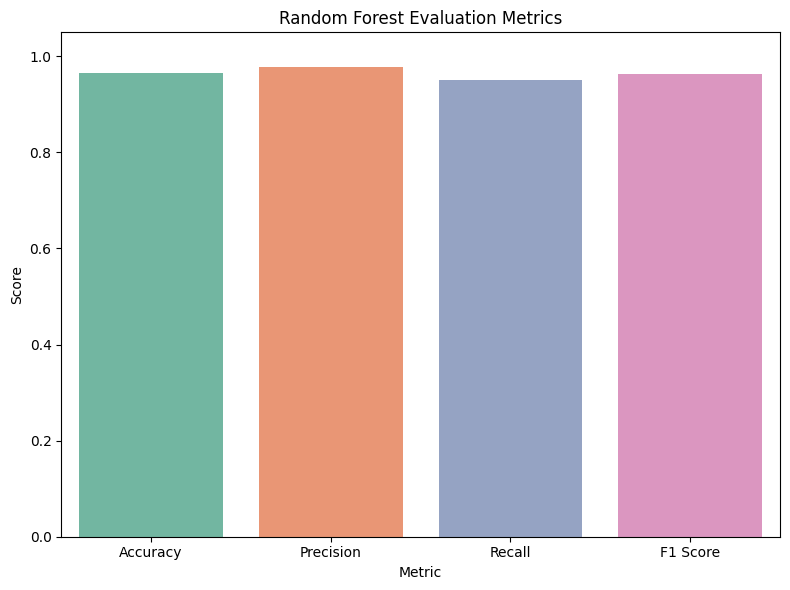

In [69]:
# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Biểu đồ các chỉ số
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=metrics, palette=colors)
plt.ylim(0.0, 1.05)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.title('Random Forest Evaluation Metrics')
plt.grid(False)
plt.tight_layout()
plt.show()

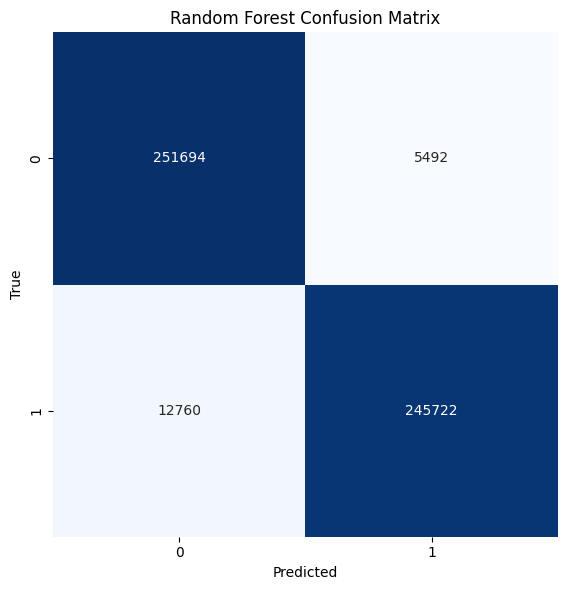

In [70]:
# Tạo confusion matrix và vẽ biểu đồ heatmap như trong hình
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN

# 1. Cân bằng dữ liệu gốc (chỉ làm 1 lần duy nhất nếu muốn fix kết quả)
smote_enn = SMOTEENN(random_state=42)
x_resample, y_resample = smote_enn.fit_resample(x_train, y_train)

# Option: lưu lại dữ liệu resample nếu cần
# np.save('x_resample.npy', x_resample)
# np.save('y_resample.npy', y_resample)

# 2. Chuẩn hóa sau khi đã cân bằng
scaler = StandardScaler()
x_resample_scaled = scaler.fit_transform(x_resample)
x_test_scaled = scaler.transform(x_test)

# 3. Huấn luyện MLPClassifier
nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate='adaptive',
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.2,  # tăng validation để ổn định dừng sớm
    n_iter_no_change=20,       # cho phép mô hình kiên nhẫn hơn
    random_state=42
)

nn_model.fit(x_resample_scaled, y_resample)


MLPClassifier(early_stopping=True, hidden_layer_sizes=(64, 32, 16),
              learning_rate='adaptive', max_iter=300, n_iter_no_change=20,
              random_state=42, validation_fraction=0.2)

In [51]:
y_pred = nn_model.predict(x_test_scaled)

In [52]:
print("classification_Neural Network_Report:\n", classification_report(y_test,y_pred))
print("Roc Auc Score: ", roc_auc_score(y_test,y_pred))

classification_Neural Network_Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94    257186
           1       0.95      0.93      0.94    258482

    accuracy                           0.94    515668
   macro avg       0.94      0.94      0.94    515668
weighted avg       0.94      0.94      0.94    515668

Roc Auc Score:  0.9442235597990414


C:\Users\DELL\AppData\Local\Temp\ipykernel_9276\3785874039.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=metrics, palette=colors)


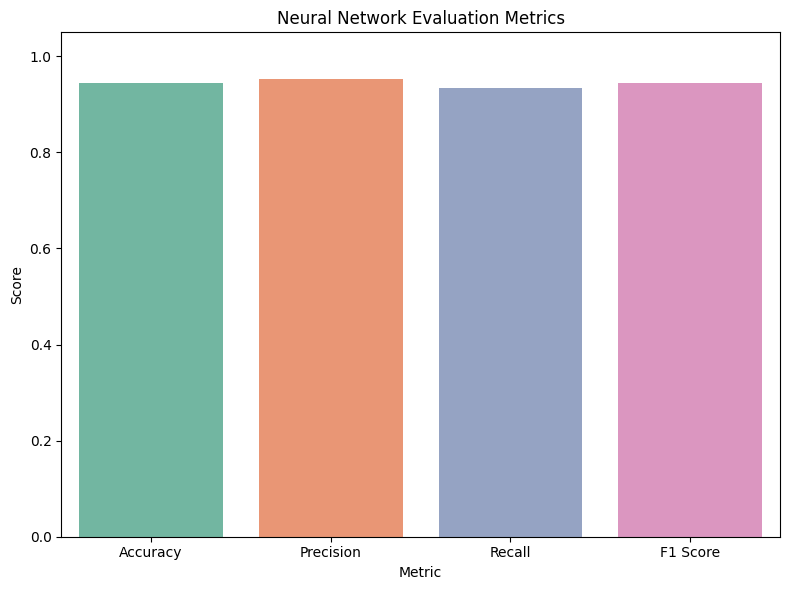

In [53]:
# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Biểu đồ các chỉ số
metrics = [accuracy, precision, recall, f1]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=metrics, palette=colors)
plt.ylim(0.0, 1.05)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.title('Neural Network Evaluation Metrics')
plt.grid(False)
plt.tight_layout()
plt.show()

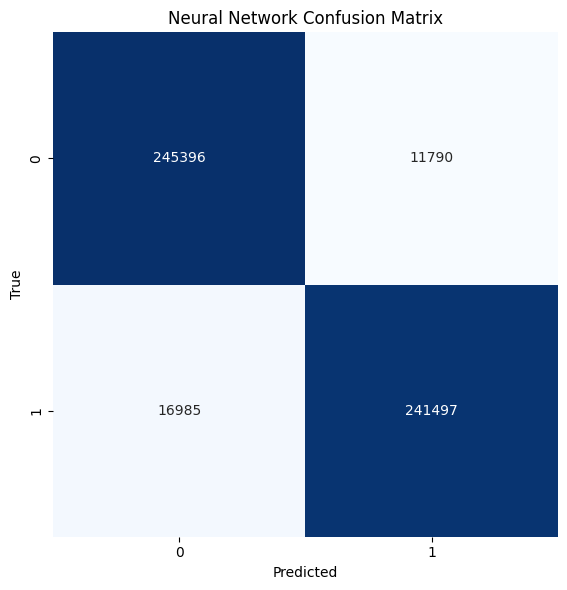

In [54]:
# Tạo confusion matrix và vẽ biểu đồ heatmap như trong hình
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False,
            xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.tight_layout()
plt.show()

In [71]:
# Decision Tree
y_score_dt = dt_model.predict_proba(x_test)[:, 1]  # lấy xác suất lớp 1

# Random Forest
y_score_rf = rf_model.predict_proba(x_test)[:, 1]

# Neural Network (nếu là sklearn MLPClassifier)
y_score_nn = nn_model.predict_proba(x_test_scaled)[:, 1]


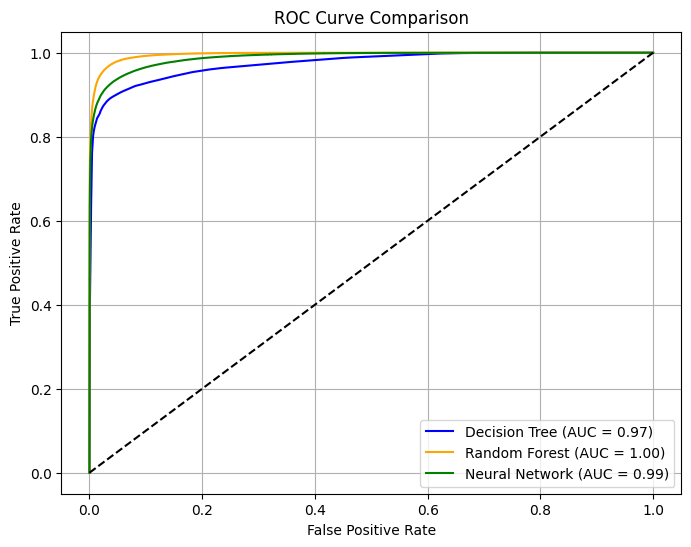

In [72]:
# Tính FPR, TPR và AUC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_score_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)

auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_nn = auc(fpr_nn, tpr_nn)

# Vẽ biểu đồ
plt.figure(figsize=(8,6))

# Vẽ từng đường ROC
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='orange')
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.2f})", color='green')

# Vẽ đường random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Thêm nhãn và tiêu đề
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [73]:
joblib.dump(rf_model, "fraud_detection_model.jb")
joblib.dump(encoders, "label_encoder.jb")

['label_encoder.jb']

The End.